# 📌 1. Загрузка и начальная проверка данных

In [1]:
import numpy as np
import pandas_ta as ta
import requests
import pandas as pd
import json
from pybit.unified_trading import HTTP
from datetime import datetime
import time
import math
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
# Исправленные импорты:
from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import EasyEnsembleClassifier  # <-- Теперь из правильного места
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score, precision_recall_curve, precision_recall_curve, roc_curve, auc, classification_report
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# from imblearn.ensemble import EasyEnsembleClassifier  # Дубликат можно удалить
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier, plot_importance
from joblib import dump, load
from scipy.signal import argrelextrema
import shap
from scipy.stats import wasserstein_distance  # Альтернатива, если нет POT
import ot
from tqdm import tqdm
import joblib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score
import importlib
import modules.indicators
importlib.reload(modules.indicators);
import sys
from modules.create_df import kline_candles, load_kline_data_from_csv
#добавление только 2 шт, т.к. они ссылаются на добавление таргетов и apply_indicators, который ссылается на сами индюки
from modules.all_kline_changes import keep_selected_features, drop_low_importance_features, apply_main_indicators, apply_indicators, add_target_column_mod, apply_add_indicators
from modules.Save_and_Load import load_model_with_threshold, save_model_with_threshold
from modules.graphs_and_tables import evaluate_model_with_threshold, plot_feature_pairplot,\
    plot_correlation_matrix, explain_model_shap, explain_model_permutation, show_rfecv_results,\
    explain_model_boruta, explain_model_mutual_info, explain_model_granger, plot_f1_vs_n_estimators,\
    show_class_balance, get_top_correlated_pairs

C:\Users\nikita\anaconda3\envs\new_env\lib\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Загрузка данных с Bybit и формирование df и целевой переменной

**Функция kline_candles состоит из основных блоков:**
1) Загружает график с биржи в формате Data, Volume, High, Low, Open, Close. На вход подаются название **торговой пары**, **таймфрейм**
2) Формирует целевой признак y = 1: рост цены на **target%** за **target_candles** с соотношением риск / прибыль **rr_threshold**
 

**Базовые параметры**:
- target_candles = 30
- target = 0.01
- rr_threshold = 2
- tf = 1
- lenght = 20
- LINKUSDT - baseline модель

In [50]:
# Запуск
if __name__ == '__main__':
    start_time = time.time()

    try:
        #для обучения start='2022-03-10 00:00', end='2024-02-10 00:00'
        # отложенная выборка start='2024-02-12 00:00', end='2024-12-12 00:00'
        df = kline_candles(symbol='LINKUSDT', tf=1, start='2022-03-10 00:00', end='2024-12-10 00:00',
                            length=20, target_candles=30, target=0.01, rr_threshold=2.0)
        df_test = kline_candles(symbol='LINKUSDT', tf=1, start='2024-12-12 00:00', end='2025-07-12 00:00', 
                           length=20, target_candles=30, target=0.01, rr_threshold=2.0)
        print("Данные успешно загружены и обработаны")
    except NameError as e:
        # Получаем информацию о месте ошибки
        tb = e.__traceback__
        line_number = tb.tb_lineno if tb else "неизвестно"
        print(f"Ошибка имени (вероятно отсутствует импорт): {e}, возникает в строке: {line_number}")
    except Exception as e:
        print(f"Другая ошибка при обработке: {e}")
    print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

Данные успешно загружены и обработаны
Время выполнения: 6043.33 сек


## Загрузка / Сохранение 

### Сохранение df на пк

Сохранение df с сырыми данными

In [7]:
df.to_csv("LINKUSDT_m1_train_raw_data.csv", index=False)
df_test.to_csv("LINKUSDT_m1_test_raw_data.csv", index=False)

Сохранение df с признаками

In [86]:
df.to_csv("LINK_train_m1_base_features.csv", index=False, compression='zstd')
df_test.to_csv("LINK_test_m1_base_features.csv", index=False, compression='zstd')

### Загрузка df

In [2]:
df= pd.read_csv('LINKUSDT_m1_train_raw_data.csv')
df_test = pd.read_csv('LINKUSDT_m1_test_raw_data.csv')
df.head(3)

,Data,Open,High,Low,Close,Volume,target
0,2022-03-09 21:01:00,13.838,13.838,13.817,13.823,1386.0,0
1,2022-03-09 21:02:00,13.823,13.855,13.823,13.855,853.7,0
2,2022-03-09 21:03:00,13.855,13.855,13.849,13.855,154.0,0


In [104]:
df= pd.read_csv('LINK_train_m1_base_features.csv', compression='zstd')
df_test = pd.read_csv('LINK_test_m1_base_features.csv', compression='zstd')
df.head(3)

,atr_24_norm,KeltnerWidth_v3,ema200_norm,ema50_norm,ema20_ema50_diff,ema50_diff_mean5,ema200_diff_mean5,vwap_intraday_norm,vwap_ema6h_norm,Data,High,Low,Close,Open,Volume,target
0,0.096074,0.104418,0.506825,0.510761,0.001403,-0.002698,-0.006634,0.510034,0.509097,2022-03-10 00:20:00,14.090,14.076,14.087,14.090,21.7,0
1,0.090431,0.103776,0.506896,0.510888,0.001450,-0.002834,-0.006826,0.510074,0.509175,2022-03-10 00:21:00,14.094,14.087,14.092,14.087,277.6,0
2,0.087281,0.103551,0.506965,0.511005,0.001480,-0.002839,-0.006878,0.510080,0.509248,2022-03-10 00:22:00,14.095,14.081,14.089,14.092,36.6,0


## Формирование цели

In [3]:
df = df.drop('target',axis=1)
df = add_target_column_mod(df, target_candles=30, target=0.01, rr_threshold=2.0)
df_test = df_test.drop('target',axis=1)
df_test = add_target_column_mod(df_test, target_candles=30, target=0.01, rr_threshold=2.0)

## Загрузка индикаторов и чистка данных

Функция **apply_main_indicators** формирует новые признаки - индикаторы для трейдинга. На вход подается **Lookback** на основании которого идет расчет краткосрочных индикаторов

In [4]:
df = apply_main_indicators(df, length = 20)
df_test = apply_main_indicators(df_test, length = 20)
df.head(3)

,Data,Open,High,Low,Close,Volume,target,RSI21,RSI_50_21_diff,ema20_norm,...,ema100_ema200_diff,vwap_ema6h_norm,vwap_ema6h_zscore,vwap_price_distance_direct,vwap_price_distance,RSI_vwap_divergence,vwap_intraday_norm,VWAP_slope,dump_return_15,fib_dist_050_last50
0,2022-03-09 21:01:00,13.838,13.838,13.817,13.823,1386.0,0,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,-1.0
1,2022-03-09 21:02:00,13.823,13.855,13.823,13.855,853.7,0,NaN,NaN,NaN,...,NaN,-0.000289,NaN,NaN,NaN,NaN,0.000588,0.0,NaN,-1.0
2,2022-03-09 21:03:00,13.855,13.855,13.849,13.855,154.0,0,NaN,NaN,NaN,...,NaN,-0.000511,NaN,NaN,NaN,NaN,0.000453,0.0,NaN,-1.0


### Оставить базовый набор индикаторов 

Базовый набор индикаторов + первичные признаки 'Data', 'High', 'Low', 'Close', 'Open', 'Volume', 'target'

In [5]:
base_features = ['ema20_norm', 
                 'ema200_norm',
                'RSI21',
                'fib_dist_050_last50',
                'vwap_price_distance',
                 'ema100_norm',
                 'RSI_50_21_diff',
                 'vwap_ema6h_norm',
                 'vwap_price_distance_direct',
                 'ema50_ema100_diff',
                 'ema200_slope',
                 'ema100_slope',
                 'ema100_ema200_diff',
                 'vwap_ema6h_zscore',
                'Data', 'High', 'Low', 'Close', 'Open', 'Volume','target']

In [6]:
df = df[base_features]
df_test = df_test[base_features]
df.head(3)

,ema20_norm,ema200_norm,RSI21,fib_dist_050_last50,vwap_price_distance,ema100_norm,RSI_50_21_diff,vwap_ema6h_norm,vwap_price_distance_direct,ema50_ema100_diff,...,ema100_slope,ema100_ema200_diff,vwap_ema6h_zscore,Data,High,Low,Close,Open,Volume,target
0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,2022-03-09 21:01:00,13.838,13.817,13.823,13.838,1386.0,0
1,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-0.000289,NaN,NaN,...,NaN,NaN,NaN,2022-03-09 21:02:00,13.855,13.823,13.855,13.823,853.7,0
2,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-0.000511,NaN,NaN,...,NaN,NaN,NaN,2022-03-09 21:03:00,13.855,13.849,13.855,13.855,154.0,0


### Добавление новых индиаторов

После формирования основных индикаторов можно эксперементировать с добавлением новых через **apply_add_indicators**

In [7]:
df = apply_add_indicators(df, length = 20)
df_test = apply_add_indicators(df_test, length = 20)


Начальное количество NaN в df: 1291
⏱️ resistance_slope_dist_200: 0.84 сек
Итоговое количество NaN в df: 1306
Начальное количество NaN в df: 1291
⏱️ resistance_slope_dist_200: 0.19 сек
Итоговое количество NaN в df: 1306


### Удаление дубликатов, Nan, inf и информация о df

In [8]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.dropna(inplace=True)
df_test = df_test.loc[:, ~df_test.columns.duplicated(keep='first')]
df_test.dropna(inplace=True)

In [9]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1448436 entries, 204 to 1448639
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ema20_norm                  1448436 non-null  float64
 1   ema200_norm                 1448436 non-null  float64
 2   RSI21                       1448436 non-null  float64
 3   fib_dist_050_last50         1448436 non-null  float32
 4   vwap_price_distance         1448436 non-null  float64
 5   ema100_norm                 1448436 non-null  float64
 6   RSI_50_21_diff              1448436 non-null  float64
 7   vwap_ema6h_norm             1448436 non-null  float64
 8   vwap_price_distance_direct  1448436 non-null  float64
 9   ema50_ema100_diff           1448436 non-null  float64
 10  ema200_slope                1448436 non-null  float64
 11  ema100_slope                1448436 non-null  float64
 12  ema100_ema200_diff          1448436 non-null  float64
 13  

((1448436, 24), None)

In [10]:
df.describe().round(3)

,ema20_norm,ema200_norm,RSI21,fib_dist_050_last50,vwap_price_distance,ema100_norm,RSI_50_21_diff,vwap_ema6h_norm,vwap_price_distance_direct,ema50_ema100_diff,...,vwap_ema6h_zscore,High,Low,Close,Open,Volume,target,atr_24_norm,atr_24_norm_velocity,atr_24_norm_acceleration
count,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,...,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000,1448436.000
mean,-0.000,-0.000,0.502,-0.958,0.002,-0.000,-0.000,-0.000,0.022,0.000,...,-0.001,10.580,10.565,10.572,10.572,4796.120,0.084,-0.221,0.000,0.000
std,0.002,0.008,0.094,0.210,1.471,0.006,0.047,0.008,5.482,0.002,...,1.689,4.416,4.408,4.412,4.412,14361.209,0.277,0.565,0.052,0.072
min,-0.048,-0.107,0.029,-1.000,-7.102,-0.082,-0.223,-0.160,-50.887,-0.038,...,-9.899,4.805,4.667,4.679,4.679,0.000,0.000,-1.000,-0.242,-0.568
25%,-0.001,-0.004,0.438,-1.000,-1.191,-0.002,-0.033,-0.003,-3.237,-0.001,...,-1.536,6.923,6.916,6.919,6.919,518.200,0.000,-0.693,-0.030,-0.036
50%,-0.000,-0.000,0.501,-1.000,0.014,-0.000,-0.000,-0.000,-0.018,0.000,...,-0.002,8.118,8.105,8.112,8.112,1594.300,0.000,-0.324,-0.005,0.001
75%,0.001,0.003,0.565,-1.000,1.202,0.002,0.033,0.002,3.257,0.001,...,1.523,14.150,14.132,14.141,14.141,4366.100,0.000,0.175,0.022,0.036
max,0.087,0.167,0.922,1.000,6.331,0.141,0.189,0.117,51.696,0.030,...,9.898,27.428,27.374,27.417,27.417,1424228.600,1.000,1.000,0.400,0.536


In [14]:
pd.set_option('display.max_columns', 200)
df.tail(3)

,ema20_norm,ema200_norm,RSI21,fib_dist_050_last50,vwap_price_distance,ema100_norm,RSI_50_21_diff,vwap_ema6h_norm,vwap_price_distance_direct,ema50_ema100_diff,ema200_slope,ema100_slope,ema100_ema200_diff,vwap_ema6h_zscore,Data,High,Low,Close,Open,Volume,target,atr_24_norm,atr_24_norm_velocity,atr_24_norm_acceleration
1448637,0.008173,0.045082,0.364483,-0.405271,-2.290333,0.032389,0.005034,0.015190,-7.058730,-0.011655,-0.016949,-0.024443,-0.012693,2.698466,2024-12-09 20:58:00,22.509,22.358,22.386,22.451,64890.1,0,0.789542,-0.042092,-0.108251
1448638,0.008641,0.046272,0.360772,-0.418981,-2.290295,0.033359,0.006594,0.015285,-6.973252,-0.011910,-0.017456,-0.025302,-0.012913,2.624832,2024-12-09 20:59:00,22.486,22.360,22.367,22.386,29393.1,0,0.738364,-0.039979,-0.027631
1448639,0.008537,0.046761,0.364704,-0.409587,-2.265964,0.033633,0.004830,0.015396,-6.887101,-0.012140,-0.017772,-0.025773,-0.013128,2.565895,2024-12-09 21:00:00,22.416,22.285,22.378,22.367,61537.7,0,0.696510,-0.035317,-0.009936


In [56]:
# Проверяем, есть ли бесконечности в данных
inf_check = df.isin([np.inf, -np.inf]).any()
print("Столбцы с inf:\n", inf_check)

# Считаем количество строк с inf в любом столбце
rows_with_inf = df.isin([np.inf, -np.inf]).any(axis=1).sum()
print(f"Всего строк с inf: {rows_with_inf}")

Столбцы с inf:
 atr_24_norm           False
KeltnerWidth_v3       False
ema200_norm           False
ema50_norm            False
ema20_ema50_diff      False
ema50_diff_mean5      False
ema200_diff_mean5     False
vwap_intraday_norm    False
vwap_ema6h_norm       False
Data                  False
High                  False
Low                   False
Close                 False
Open                  False
Volume                False
target                False
dtype: bool
Всего строк с inf: 0


In [446]:
# Удаляем строки, где есть хотя бы одно inf
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

# Проверяем, что inf больше нет
print("Остались ли inf после удаления:", df.isin([np.inf, -np.inf]).any().any())

Остались ли inf после удаления: False


# ✂️ 2. Разбиение выборки

## Разбиение выборки на train и valid

In [15]:
#Разбиваем выборку с учетом временных рядов:

X = df.drop(['target','Data','High','Low','Close','Open', 'Volume'],axis=1)
y = df['target']
separate = int(len(X) * 0.8)
X_train = X.iloc[:separate]
X_valid = X.iloc[separate:]
y_train = y.iloc[:separate]
y_valid = y.iloc[separate:]
feature_columns = X.columns.tolist()

print(f'размер датасета = {df.shape}')
print(f'размер обучающей выборки Х = {X_train.shape}, y = {y_train.shape}')
print(f'размер валидационной выборки Х = {X_valid.shape}, y = {y_valid.shape}')

размер датасета = (1448436, 24)
размер обучающей выборки Х = (1158748, 17), y = (1158748,)
размер валидационной выборки Х = (289688, 17), y = (289688,)


Разбиение тестовой выборки **X_test**, **y-test**

In [16]:
X_test = df_test.drop(['target','Data','High','Low','Close','Open', 'Volume'],axis=1)
y_test = df_test['target']


print(f'размер датасета = {X_test.shape}')

размер датасета = (305076, 17)


## Проверка временных диапазонов

Проверка временных диапазонов. Даты обучающей и тестовой выборок не должны пересекаться.

In [11]:
print(f"Диапазон дат обучающей выборки {df['Data'].agg(['min', 'max'])}")
print(f"Диапазон дат отложенной (тестовой) выборки {df_test['Data'].agg(['min', 'max'])}")

Диапазон дат обучающей выборки min    2022-03-10 00:25:00
max    2024-12-09 21:00:00
Name: Data, dtype: object
Диапазон дат отложенной (тестовой) выборки min    2024-12-12 00:25:00
max    2025-07-11 21:00:00
Name: Data, dtype: object


# 📊 3. Распределение целевой переменной (target)

**Цель**: определение дисбаланса классов

#### Распределение целевой переменной на всем df

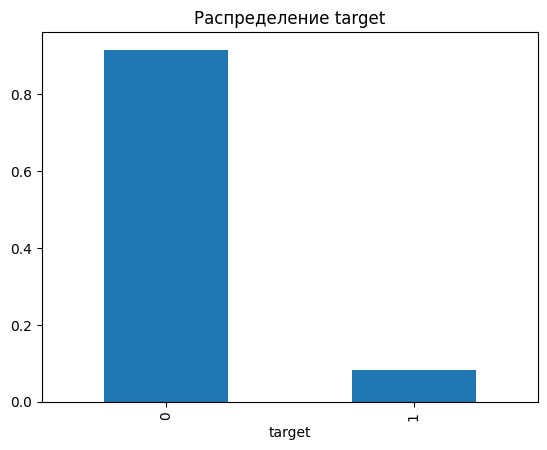

In [12]:
df['target'].value_counts(normalize=True).plot(kind='bar', title='Распределение target');

#### Распределение целевой переменной внутри выборок

Функция **show_class_balance** принимает Series с целевой переменой: **y**, **y_train**, **y_valid**, **y_test** и считает баланс классов

📊 Баланс классов (доли):
  target    Весь датасет    Обучающая    Валидационная    Тестовая
--------  --------------  -----------  ---------------  ----------
       0           0.916        0.916            0.917       0.880
       1           0.084        0.084            0.083       0.120


<Figure size 1000x500 with 0 Axes>

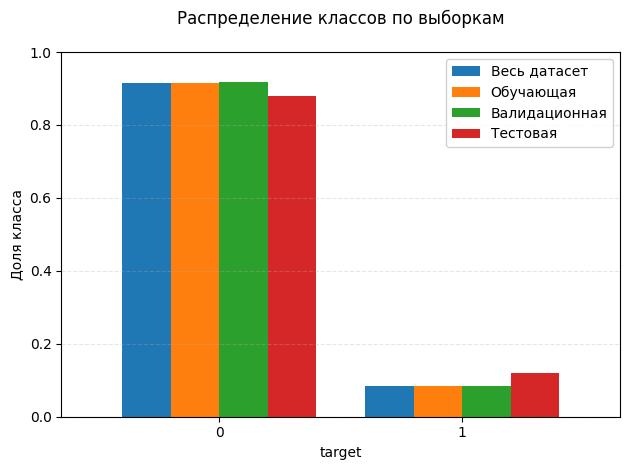

In [13]:
show_class_balance(y, y_train, y_valid, y_test);

# 📈 4. Временной анализ

## Временной анализ целевой переменной

**Цель**: проверить поведение target и цены во времени

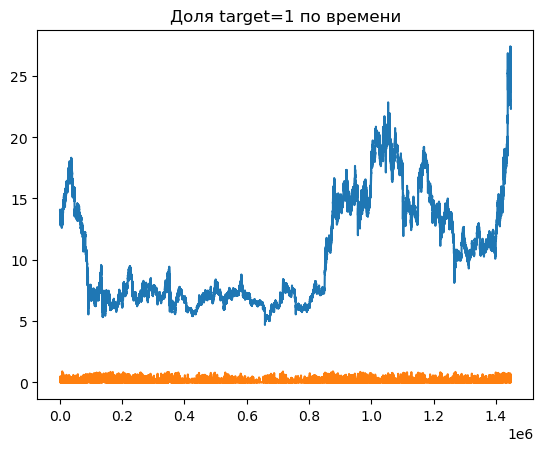

In [117]:
df['Close'].plot(title='Цена LINKUSDT')
df['target'].rolling(100).mean().plot(title='Доля target=1 по времени');

## Распределение признаков по времени

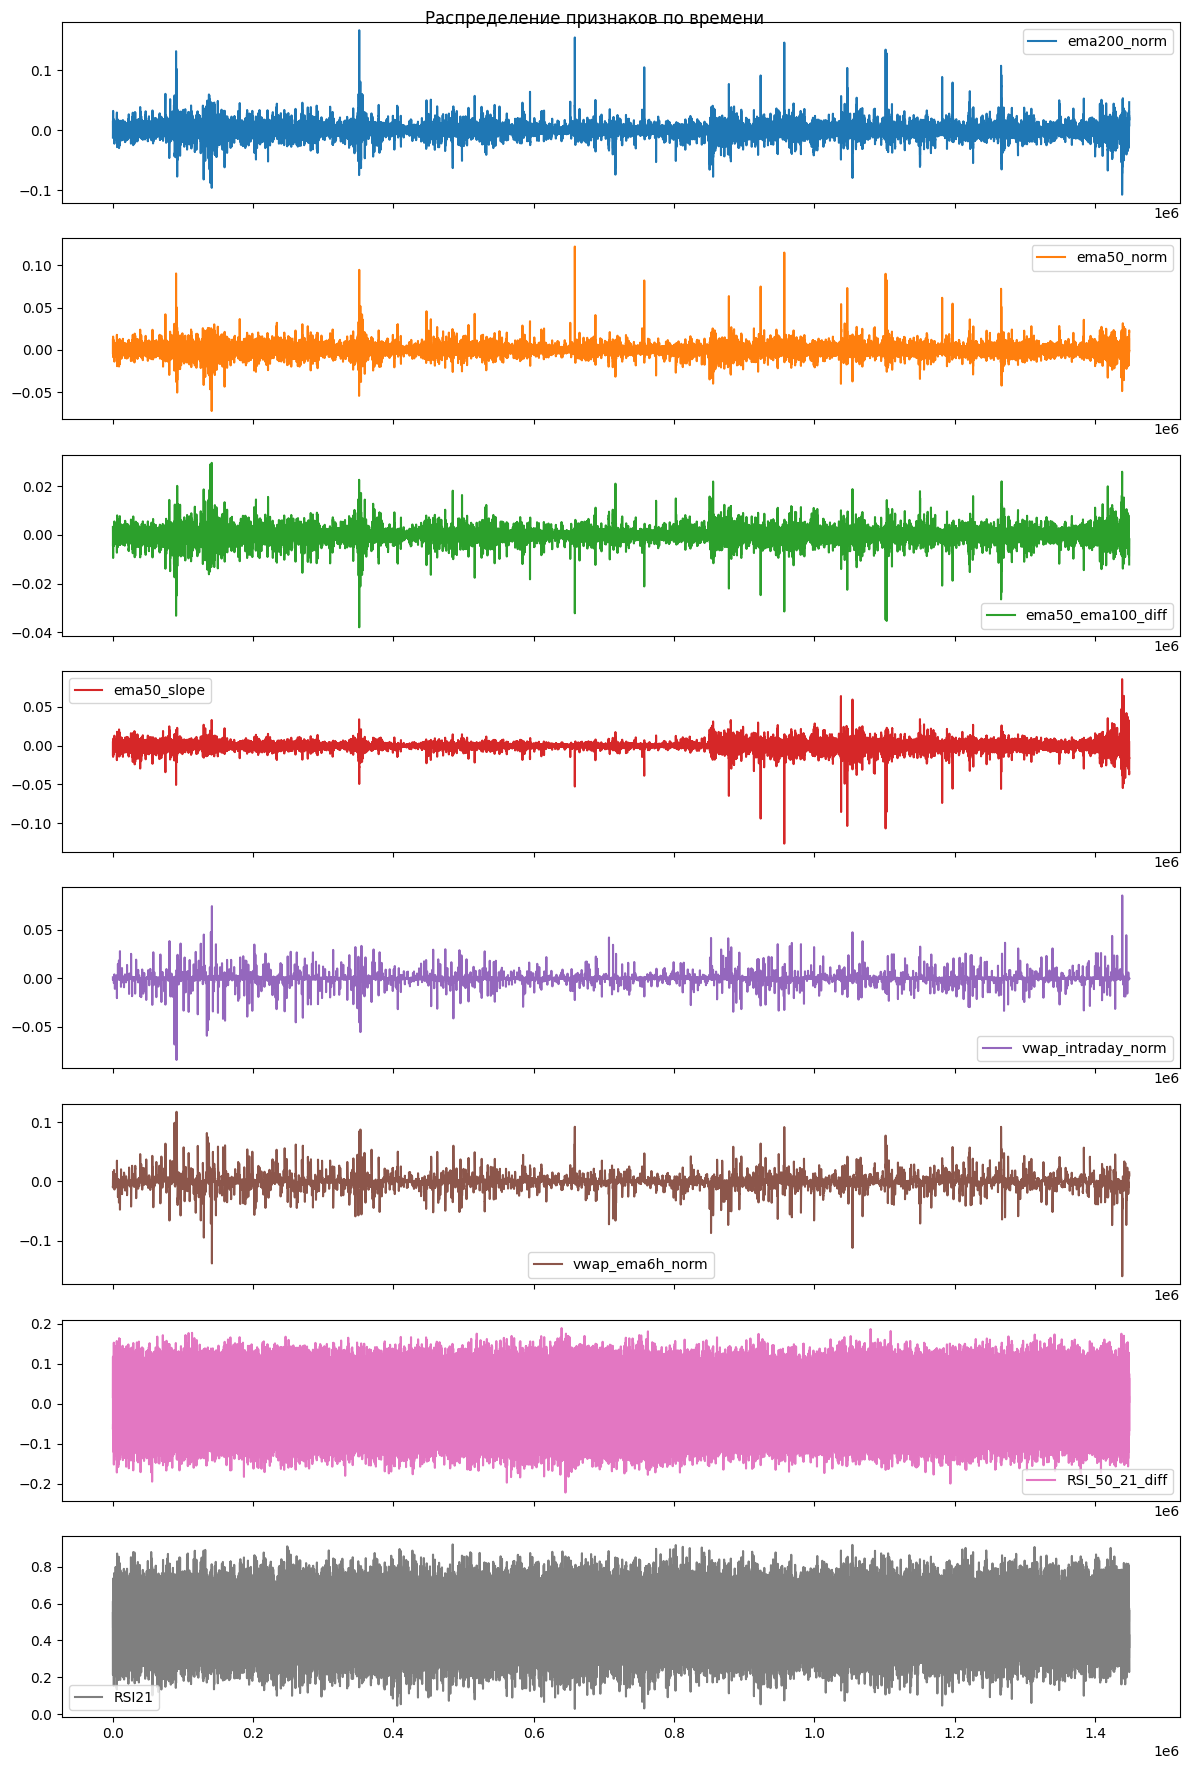

In [15]:
features = ['ema200_norm', 'ema50_norm',
            'ema50_ema100_diff', 'ema50_slope',
            'vwap_intraday_norm', 'vwap_ema6h_norm', 'RSI_50_21_diff', 'RSI21']

# Создаем отдельные графики для каждого признака
df[features].plot(subplots=True, figsize=(12, 18), layout=(len(features), 1),
                 title='Распределение признаков по времени', sharex=True)
plt.tight_layout()

# ⚙️ 5. Статистика по индикаторам

## Сравнение цены и индикаторов

**Цель**: понять распределение и выбросы

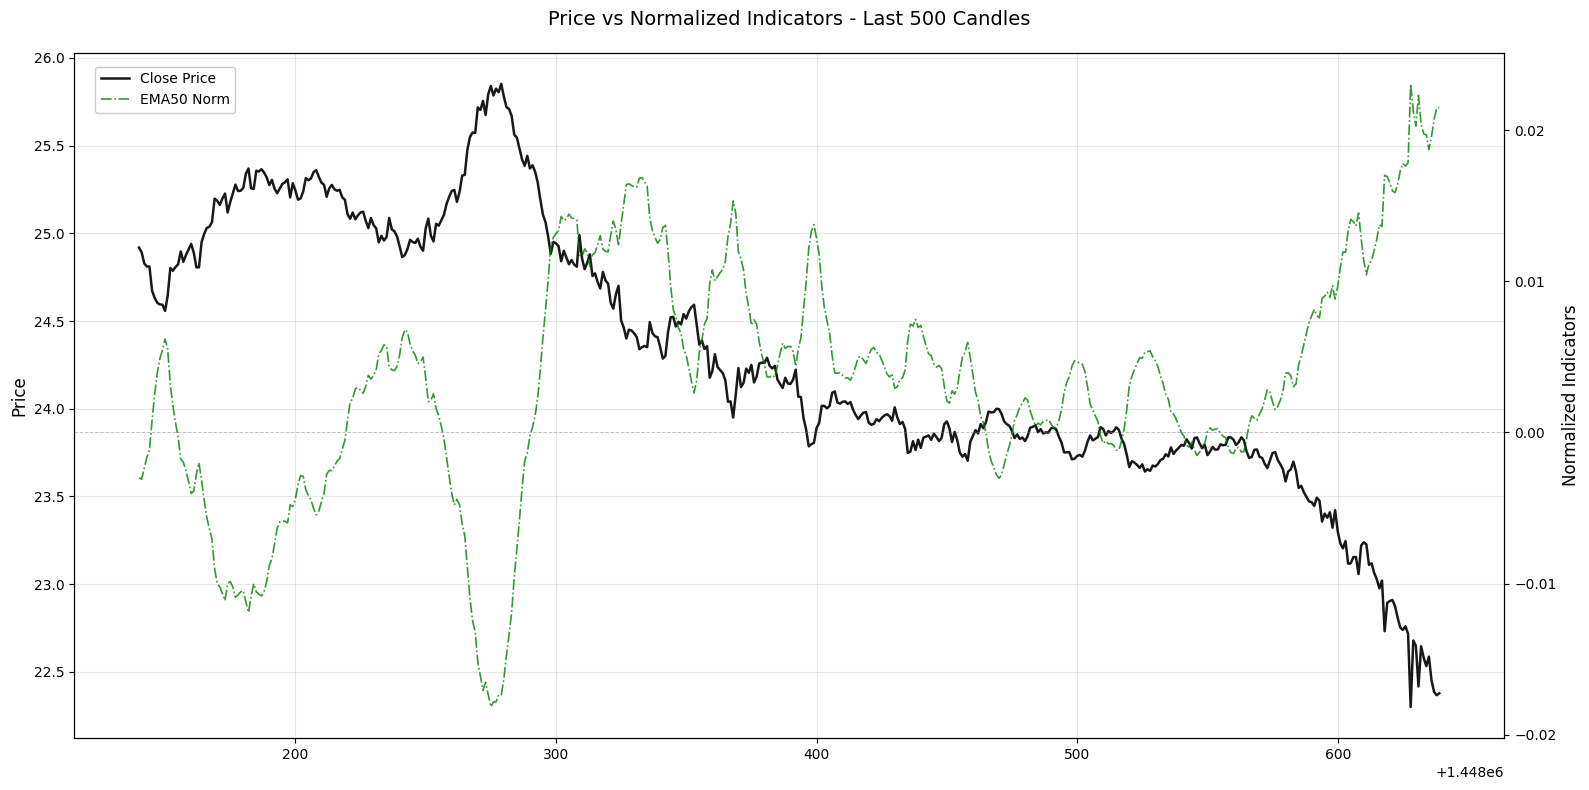

In [18]:
# Выбираем последние 500 свечей для анализа
plot_data = df.iloc[-500:].copy()

# Создаем фигуру с двумя осями Y
plt.figure(figsize=(16, 8))

# Первая ось (цена)
ax1 = plt.gca()
ax1.plot(plot_data['Close'], 
         label='Close Price', 
         color='black', 
         linewidth=1.8,
         alpha=0.9)
ax1.set_ylabel('Price', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Вторая ось (нормализованные признаки)
ax2 = ax1.twinx()

# Графики нормализованных признаков с разными цветами и стилями

# ax2.plot(plot_data['ema50_ema100_diff'], 
#          label='EMA50 Diff Mean5', 
#          color='blue',
#          linestyle='--',
#          linewidth=1.2,
#          alpha=0.8)

ax2.plot(plot_data['ema50_norm'], 
         label='EMA50 Norm', 
         color='green',
         linestyle='-.',
         linewidth=1.2,
         alpha=0.8)

# ax2.plot(plot_data['vwap_intraday_norm'], 
#          label='VWAP Intraday Norm', 
#          color='purple',
#          linestyle=':',
#          linewidth=1.5,
#          alpha=0.9)

ax2.set_ylabel('Normalized Indicators', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Добавляем легенды
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Объединяем легенды и размещаем их в одном месте
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left',
           bbox_to_anchor=(0.01, 0.99),
           framealpha=1,
           fontsize=10)

# Добавляем горизонтальную линию на уровне 0 для нормированных показателей
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

plt.title('Price vs Normalized Indicators - Last 500 Candles', fontsize=14, pad=20)
plt.tight_layout()
#ax2.set_ylim(0.8, 0.99)  # Фиксируем диапазон для нормализованных показателей
plt.show()

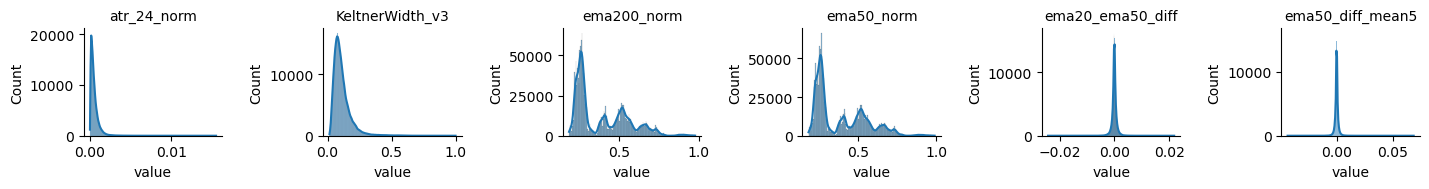

In [112]:
# Подготовка данных для FacetGrid
num_features = df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1).columns
# Выбор признаков для описания num_features[20:30]
plot_data = pd.melt(df[num_features[0:6]])

# Создаем сетку графиков
g = sns.FacetGrid(plot_data, col="variable", col_wrap=6, sharex=False, sharey=False, height=2, aspect=1.2)
g.map(sns.histplot, "value", kde=True)
g.set_titles("{col_name}")
plt.show()

# 📉 6. Корреляционный анализ

Функция **plot_correlation_matrix** принимает на вход df и возвращает корреляционную матрицу признаков включая целевую переменную.\
Не учитываются абсолютные значения цен графика.

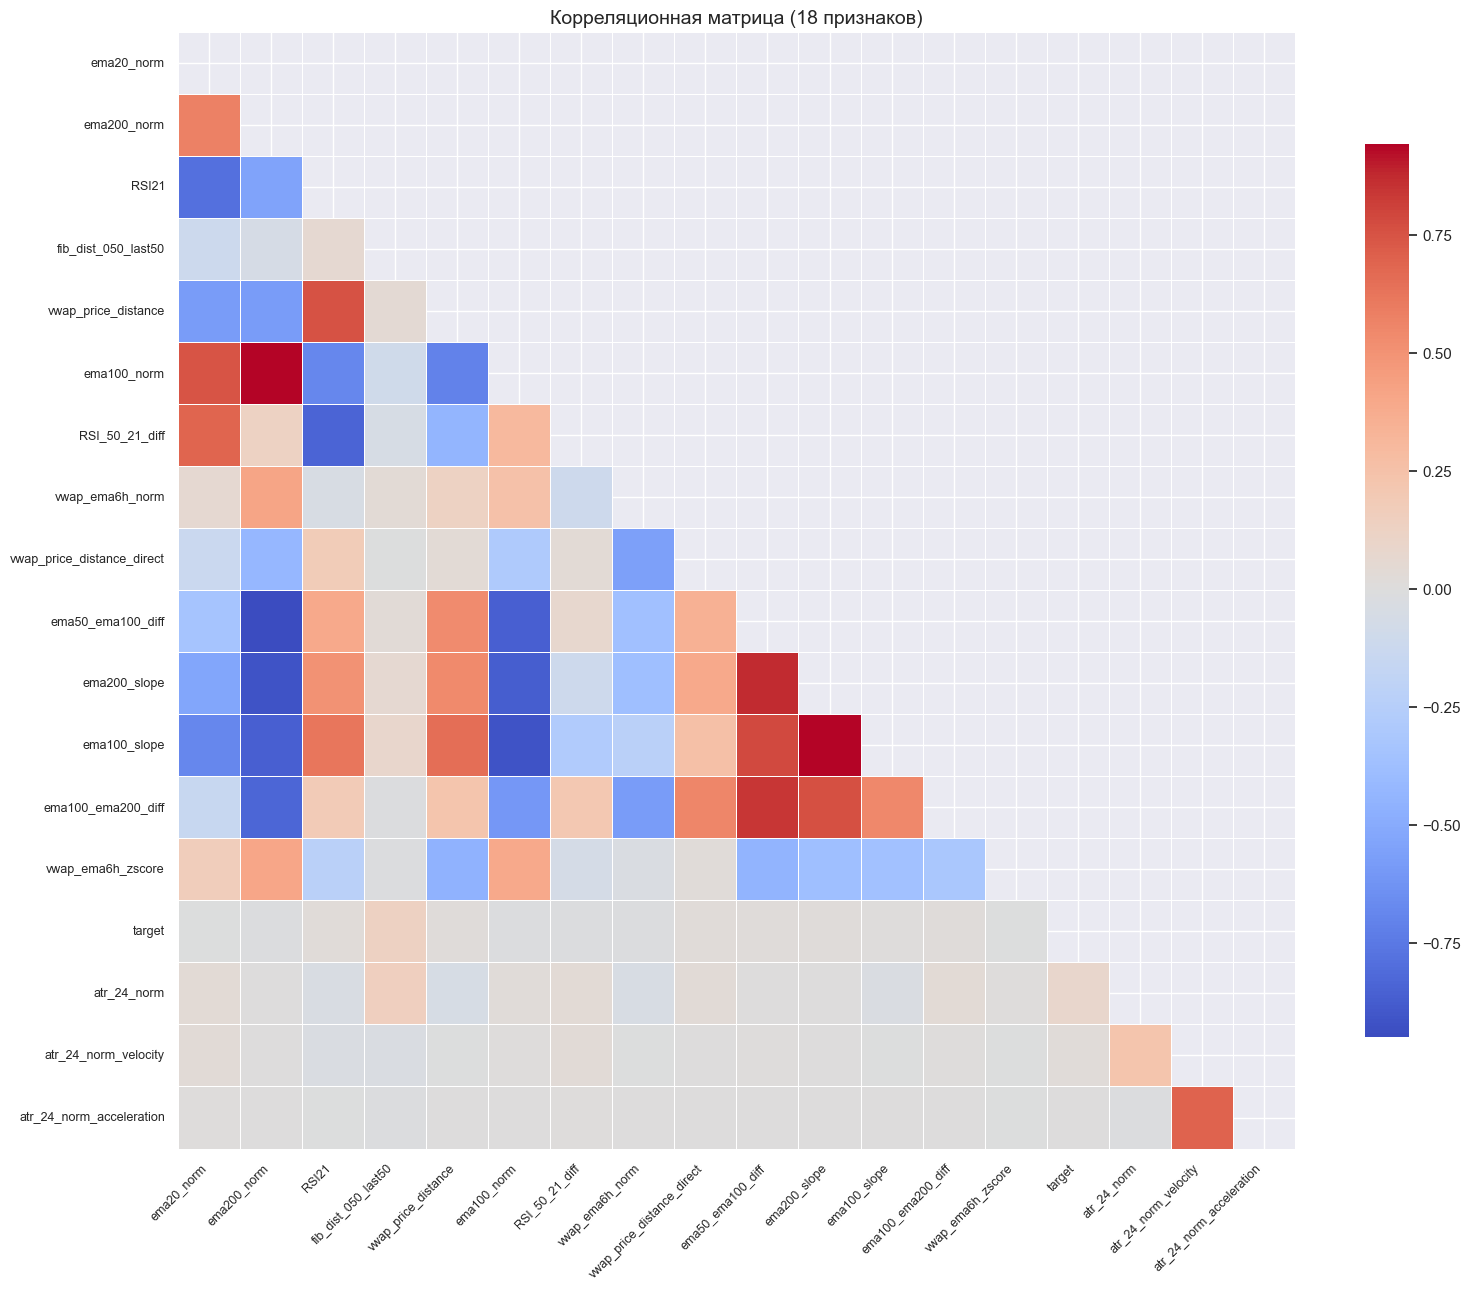

In [17]:
plot_correlation_matrix(df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1))

In [18]:
get_top_correlated_pairs(df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1,errors='ignore'),top_n=10)

Топ-10 пар по корреляции:
ema200_norm : ema50_ema100_diff : 0.9487
ema200_slope : ema100_slope : 0.9430
ema200_norm : ema100_norm : 0.9426
ema200_norm : ema200_slope : 0.9177
ema100_norm : ema100_slope : 0.9161
ema50_ema100_diff : ema200_slope : 0.8695
ema100_norm : ema200_slope : 0.8677
ema100_norm : ema50_ema100_diff : 0.8636
ema200_norm : ema100_slope : 0.8613
ema50_ema100_diff : ema100_ema200_diff : 0.8443


# 📦 7. Feature Importance (до моделей)

**Цель**: понять, какие признаки наиболее важны\
**mutual_info_classif** вычисляет взаимную информацию между каждым признаком и целевой переменной.\
Оценивает нелинейные зависимости: Может выявить сложные связи, которые пропускает линейная корреляция

ℹ️ Calculating Mutual Information for 22 features...
✅ MI calculation completed in 306.61 seconds

🔍 Top 20 Features by Mutual Information:
| Feature                    |   MI_Score |
|:---------------------------|-----------:|
| fib_dist_050_last50        |     0.2347 |
| ema100_norm                |     0.0141 |
| ema200_norm                |     0.0139 |
| ema20_norm                 |     0.0135 |
| ema50_norm                 |     0.0133 |
| dump_return_15             |     0.0128 |
| ema20_ema50_diff           |     0.0127 |
| ema50_ema100_diff          |     0.0124 |
| ema200_slope               |     0.0122 |
| ema100_slope               |     0.0118 |
| ema100_ema200_diff         |     0.0115 |
| ema50_slope                |     0.0112 |
| ema20_slope                |     0.0106 |
| vwap_intraday_norm         |     0.0103 |
| VWAP_slope                 |     0.0100 |
| RSI21                      |     0.0088 |
| RSI_50_21_diff             |     0.0080 |
| vwap_ema6h_norm       

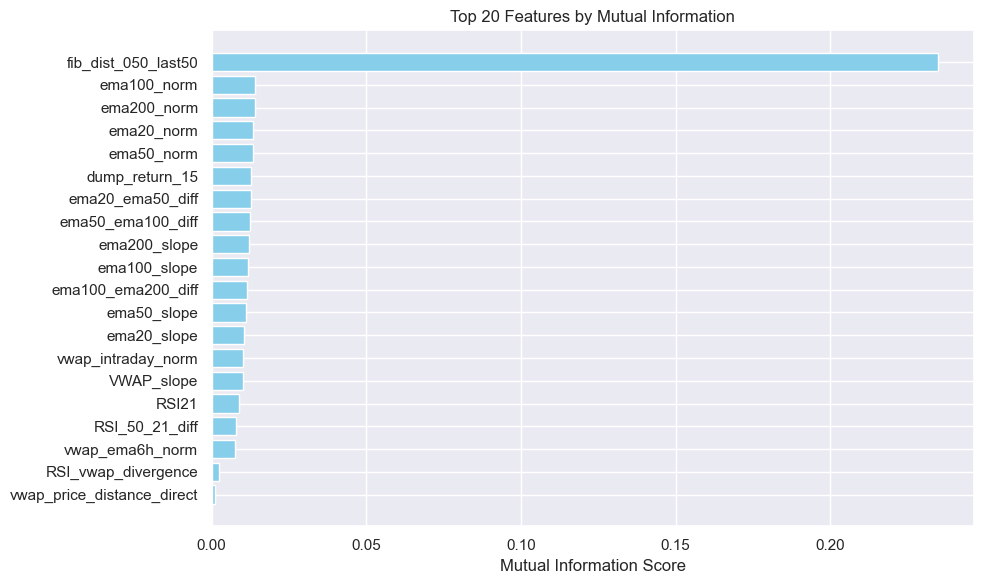

In [21]:
explain_model_mutual_info(X_train, y_train, top_n=20)

Точечный график распределения **целевой переменной**.\
Визуализация парных взаимосвязей между признаками и целевой переменной

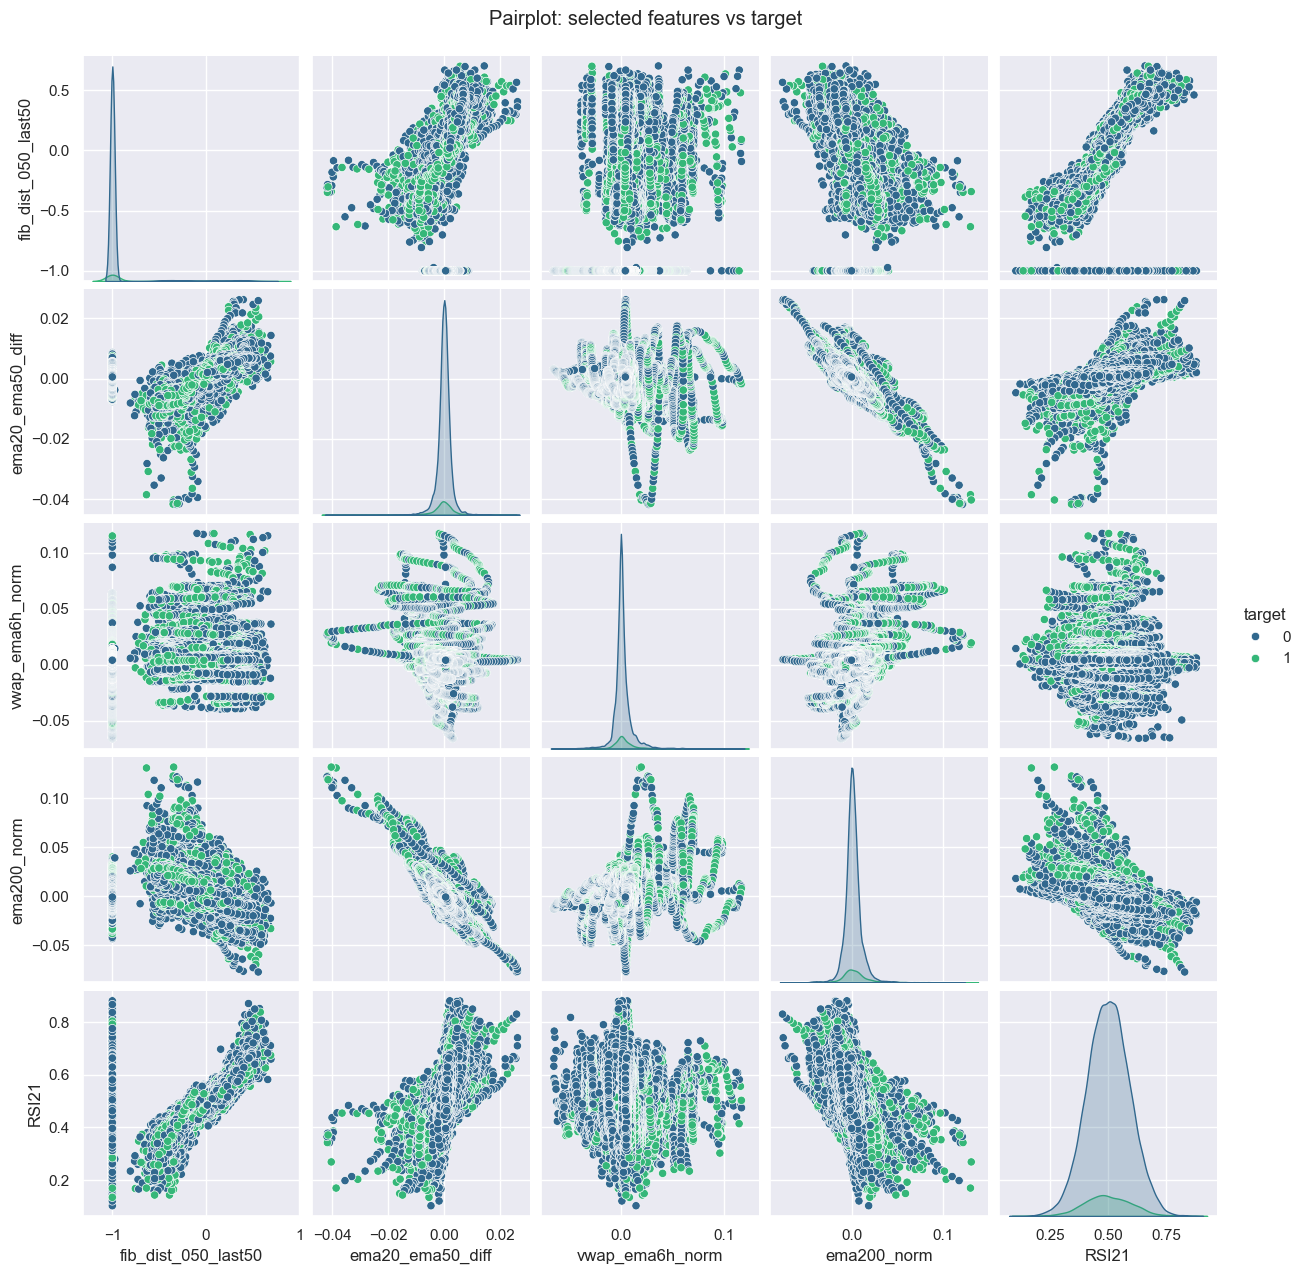

In [22]:
df_cut = df.iloc[10000:100000]
plot_feature_pairplot(df_cut, ['fib_dist_050_last50', 'ema20_ema50_diff', 'vwap_ema6h_norm', 'ema200_norm', 'RSI21'])

# 🤖 8. Обучение моделей (LogReg, RandomForest)

## Логистическая регрессия - base line

In [19]:
start_time = time.time()

# Модели и метрики по каждому таргету

y_train_single = y_train
y_valid_single = y_valid

logreg = LogisticRegression(
        class_weight='balanced',
        random_state=3,
        max_iter=100,  
        n_jobs=-1,      
        solver='lbfgs'  
    )
logreg.fit(X_train, y_train_single)
y_pred = logreg.predict(X_valid)

f1 = f1_score(y_valid_single, y_pred)
precision = precision_score(y_valid_single, y_pred)
recall = recall_score(y_valid_single, y_pred)

print(f'✅ F1 score (target): {f1:.4f}')
print(f'✅ Precision (target): {precision:.4f}')
print(f'✅ Recall (target): {recall:.4f}')
# Сохраняем модель
trained_logreg = logreg    

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.1870
✅ Precision (target): 0.1151
✅ Recall (target): 0.4988
⏱ Время выполнения: 12.17 сек


## Случайный лес - base line

In [20]:
start_time = time.time()

# Определение target_name (пример)
target_name = 'target'

# Модели и метрики по каждому таргету
y_train_single = y_train
y_valid_single = y_valid

# Более оптимальные параметры
forest_base_line = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=6,
    max_features=0.8,
    max_samples=0.8,
    random_state=3,
    n_jobs=6
)

# Обучение с кросс-валидацией (опционально)
forest = forest_base_line.fit(X_train, y_train_single)

# Предсказание
y_pred = forest_base_line.predict(X_valid)

# Расчет метрик
f1 = f1_score(y_valid_single, y_pred)
precision = precision_score(y_valid_single, y_pred)
recall = recall_score(y_valid_single, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.2535
✅ Precision (target): 0.1573
✅ Recall (target): 0.6525
⏱ Время выполнения: 482.29 сек


In [21]:
forest_base_line.feature_names_in_

array(['ema20_norm', 'ema200_norm', 'RSI21', 'fib_dist_050_last50',
       'vwap_price_distance', 'ema100_norm', 'RSI_50_21_diff',
       'vwap_ema6h_norm', 'vwap_price_distance_direct',
       'ema50_ema100_diff', 'ema200_slope', 'ema100_slope',
       'ema100_ema200_diff', 'vwap_ema6h_zscore', 'atr_24_norm',
       'atr_24_norm_velocity', 'atr_24_norm_acceleration'], dtype=object)

**Сохранения модели RandomForest Base line**

In [22]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='forest_base_line',
    model=forest_base_line,
    params=forest_base_line.get_params,
    threshold=0.5, #logreg_package['metrics']['optimal_threshold'] - путь для функции evaluate_model_with_threshold
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\forest_base_line_with_threshold.pkl (сжатие: уровень 3)


**Загрузка модели RandomForest**

In [16]:
import joblib
forest_base_line_package = load_model_with_threshold('forest_base_line')  # Обратите внимание на имя переменной
forest_base_line = forest_base_line_package['model']
forest_base_line_params = forest_base_line_package['params']
forest_base_line_threshold = forest_base_line_package['threshold']

✅ Модель 'forest_base_line' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\forest_base_line_with_threshold.pkl


# 🎯 9. Метрики: Precision, Recall, F1

Сравнение метрик **Random Forest** и **LogisticRegression**

In [23]:
y_proba_forest = forest_base_line.predict_proba(X_valid)[:, 1]       # Предсказанная вероятность
y_pred_forest = (y_proba_forest >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Random Forest')
print("Precision:", precision_score(y_valid, y_pred_forest))
print("Recall:", recall_score(y_valid, y_pred_forest))
print("F1 Score:", f1_score(y_valid, y_pred_forest))
print()
y_proba_logreg = trained_logreg.predict_proba(X_valid)[:, 1]       # Предсказанная вероятность
y_pred_logreg = (y_proba_logreg >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Log Reg')
print("Precision:", precision_score(y_valid, y_pred_logreg))
print("Recall:", recall_score(y_valid, y_pred_logreg))
print("F1 Score:", f1_score(y_valid, y_pred_logreg))

Метрики для модели Random Forest
Precision: 0.1573262193587356
Recall: 0.652526096033403
F1 Score: 0.25352638196049804

Метрики для модели Log Reg
Precision: 0.11506010171058714
Recall: 0.4987891440501044
F1 Score: 0.1869863978587193


Построение **precision-recall** кривой для модели с наивысшим значением **f1**.\
Позволяет визуально выбрать лучший порог вероятности:

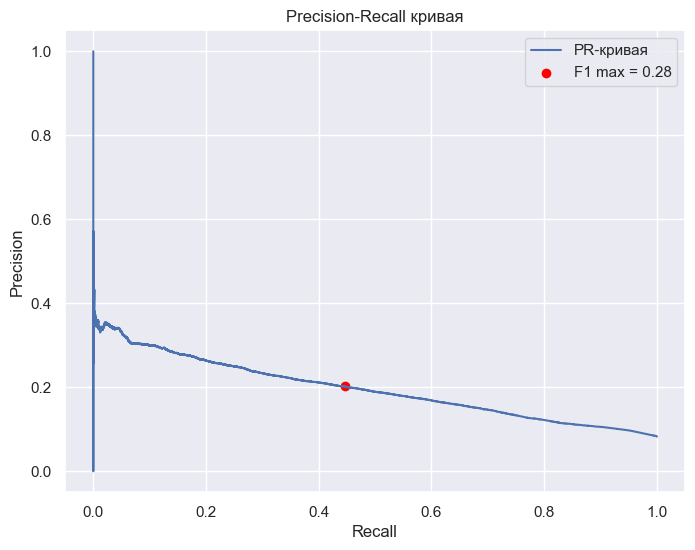

🔎 Лучший порог = 0.603, F1 = 0.278


In [24]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba_forest)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR-кривая")
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"F1 max = {f1_scores[best_idx]:.2f}")
plt.title("Precision-Recall кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔎 Лучший порог = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# ⚖️ 10. Анализ попрога вхождения для модели

Функция **evaluate_model_with_threshold** анализирует модель бинарной классификации, подбирая оптимальный порог вероятности для предсказаний.\
Сравнивает метрики (**F1, Precision, Recall, ROC-AUC**) на тренировочной, валидационной и тестовой выборках, визуализирует зависимость метрик от порога и возвращает итоговые результаты.

🎯 Лучший порог по F1 (Train): 0.6200
🎯 Лучший порог по F1 (Valid): 0.6000
✅ Усредненный оптимальный порог: 0.6100

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.7274
✅ Valid ROC AUC: 0.7210

📊 Train set (Threshold = 0.6100):
✅ F1: 0.2882
✅ Precision: 0.2121
✅ Recall: 0.4496
✅ ROC AUC: 0.7274

📊 Valid set (Threshold = 0.6100):
✅ F1: 0.2771
✅ Precision: 0.2042
✅ Recall: 0.4309
✅ ROC AUC: 0.7210

📊 Test set (Threshold = 0.6100):
✅ F1: 0.2856
✅ Precision: 0.2170
✅ Recall: 0.4178
✅ ROC AUC: 0.6628


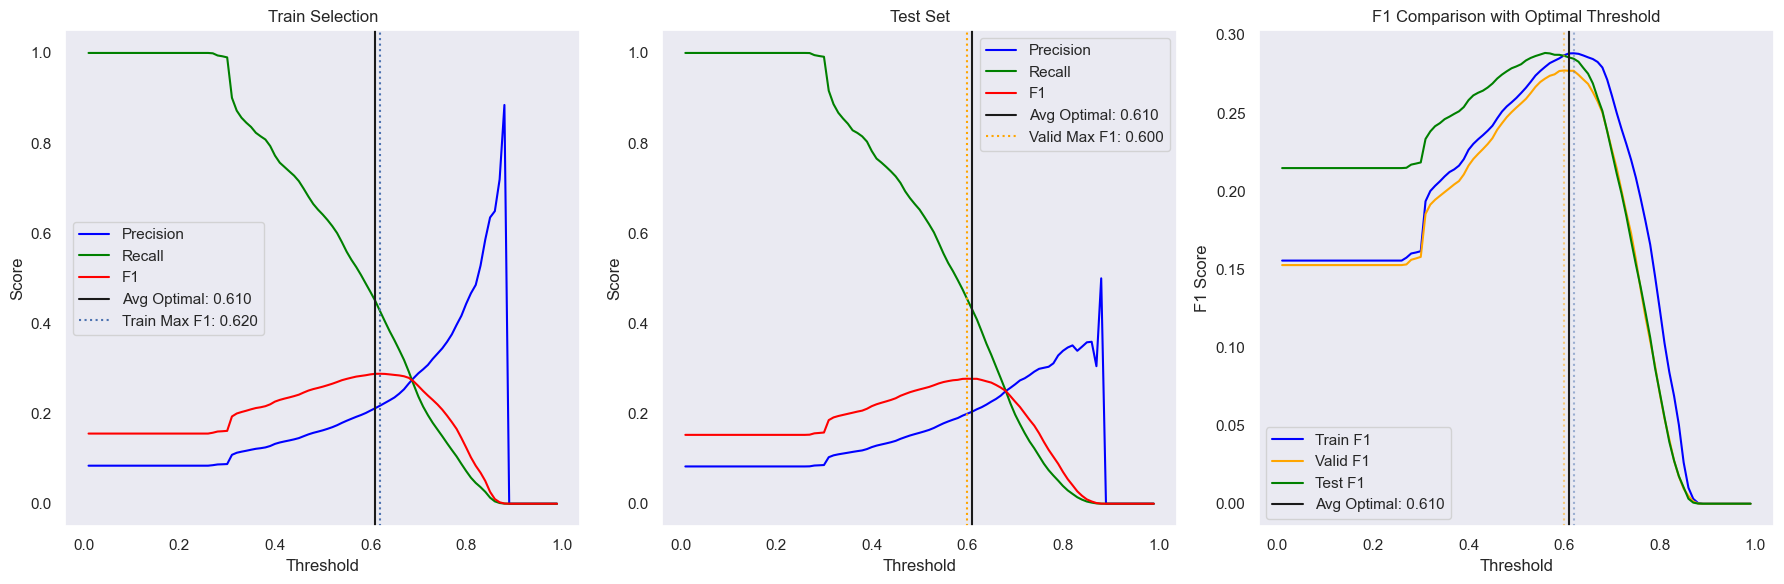


Итоговые метрики со средним оптимальным порогом:
+-----------+--------------------------+--------+-------------+----------+-----------+
| Dataset   | Threshold Type           |     F1 |   Precision |   Recall |   ROC_AUC |
+===========+==========================+========+=============+==========+===========+
| Train     | Average Optimal (0.6100) | 0.2882 |      0.2121 |   0.4496 |    0.7274 |
+-----------+--------------------------+--------+-------------+----------+-----------+
| Test      | Average Optimal (0.6100) | 0.2771 |      0.2042 |   0.4309 |    0.7210 |
+-----------+--------------------------+--------+-------------+----------+-----------+
| Test      | Average Optimal (0.6100) | 0.2856 |      0.2170 |   0.4178 |    0.6628 |
+-----------+--------------------------+--------+-------------+----------+-----------+


In [25]:
forest_base_line_package = evaluate_model_with_threshold(forest, X_train, y_train, X_valid, y_valid, X_test, y_test)

# 🧠 11. Интерпретация влияния признаков на модель 

## SHAP (SHapley Additive exPlanations)

**SHAP** - это метод объяснения предсказаний модели, основанный на теории игр (значения Шепли).\
Он показывает вклад каждого признака в конкретное предсказание, учитывая все возможные комбинации признаков.

ℹ️ Model type: RandomForestClassifier
ℹ️ Number of classes: 2
🔄 Initializing SHAP explainer...
✅ SHAP explainer initialized in 0:00:00.007965

🔄 Calculating SHAP values for 10000 samples...
✅ SHAP values calculated in 0:00:09.134611
⏱ Average time per sample: 0.0009 seconds
ℹ️ Processed SHAP values shape: (10000, 17)

🔄 Calculating feature importance...
✅ Feature analysis completed in 0:00:00.070578

🔍 Top Features by SHAP Importance:
|   Rank | Feature                    |   SHAP_% | Direction   |   Model_% |
|-------:|:---------------------------|---------:|:------------|----------:|
|      1 | ema200_norm                |    100.0 | Negative    |     100.0 |
|      2 | ema20_norm                 |     77.5 | Negative    |      64.0 |
|      3 | ema100_norm                |     51.7 | Negative    |      54.4 |
|      4 | ema100_ema200_diff         |     38.3 | Negative    |      28.9 |
|      5 | vwap_ema6h_norm            |     38.0 | Negative    |      21.8 |
|      6 | fib_dist_05

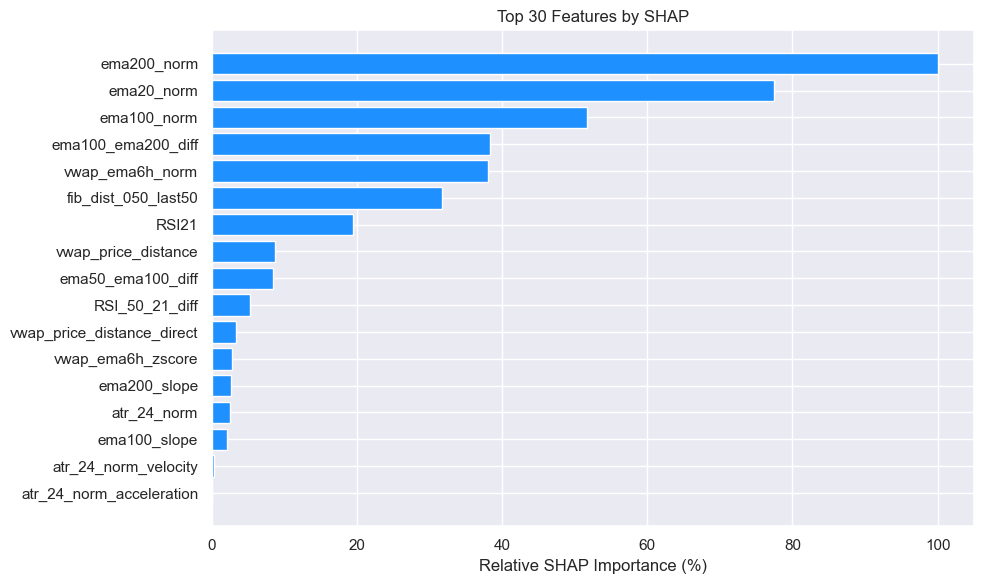


⏱ Total execution time: 0:00:09.787124
Time breakdown:
- Explainer init: 0:00:00.007965
- SHAP values: 0:00:09.134611 (93.3%)
- Analysis: 0:00:00.070578 (0.7%)


In [26]:
# Пример использования:
# explain_model_shap(X_train, logreg_model)
explain_model_shap(X_train, forest_base_line, sample_size=10000, top_n=30);

## Permutation Importance (Перестановочная важность)

**Permutation Importance** – это метод оценки важности признаков, основанный на ухудшении качества модели при случайном перемешивании значений признака.\
Если после перемешивания метрика модели значительно падает, признак считается важным.

ℹ️ Model type: RandomForestClassifier
ℹ️ Scoring metric: f1
🔄 Calculating permutation importance...
✅ Completed in 0:01:58.629788

🔍 Top Features by Permutation Importance:
|   Rank | Feature                    |   Mean Importance |   Std | Significant   |
|-------:|:---------------------------|------------------:|------:|:--------------|
|      1 | ema20_norm                 |             0.053 | 0.000 | True          |
|      2 | ema200_norm                |             0.030 | 0.000 | True          |
|      3 | RSI21                      |             0.014 | 0.000 | True          |
|      4 | fib_dist_050_last50        |             0.010 | 0.000 | True          |
|      5 | ema100_norm                |             0.009 | 0.000 | True          |
|      6 | vwap_ema6h_norm            |             0.009 | 0.000 | True          |
|      7 | vwap_price_distance        |             0.006 | 0.000 | True          |
|      8 | RSI_50_21_diff             |             0.003 | 0.000 | Tru

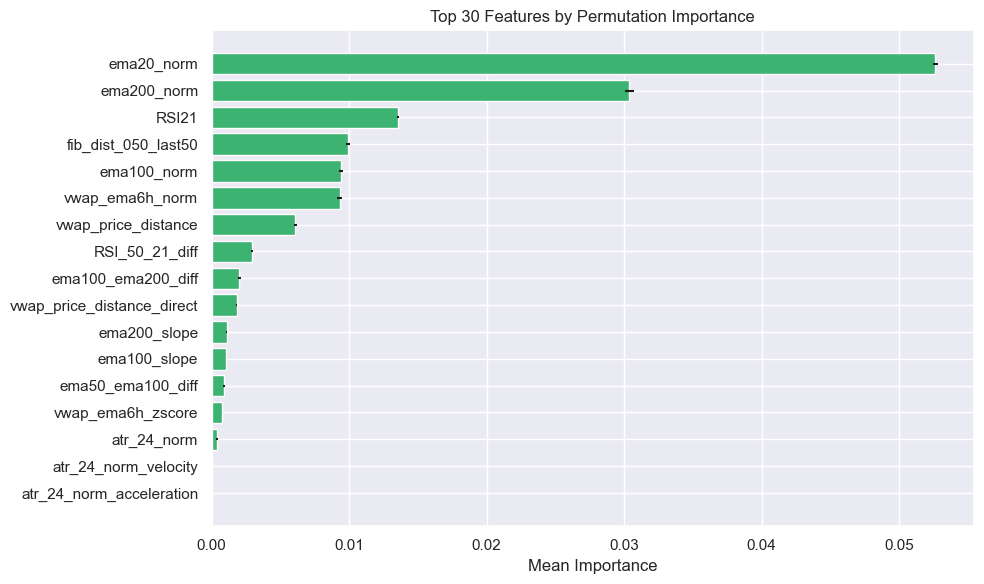

In [27]:
permutation_result = explain_model_permutation(X_train, y_train, forest, scoring='f1', top_n=30);

## RFECV (Recursive Feature Elimination with Cross-Validation) + TimeSeriesSplit

**RFECV** – это метод автоматического выбора оптимального набора признаков для модели машинного обучения, сочетающий рекурсивное исключение признаков (RFE) и кросс-валидацию TimeSeriesSplit (TSCV).

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.

✅ Признаки, отобранные RFECV:
['ema20_norm', 'ema200_norm', 'RSI21', 'fib_dist_050_last50', 'ema100_norm', 'RSI_50_21_diff', 'vwap_ema6h_norm', 'ema50_ema100_diff', 'ema200_slope', 'ema100_slope', 'ema100_ema200_diff', 'atr_24_norm', 'atr_24_norm_velocity']


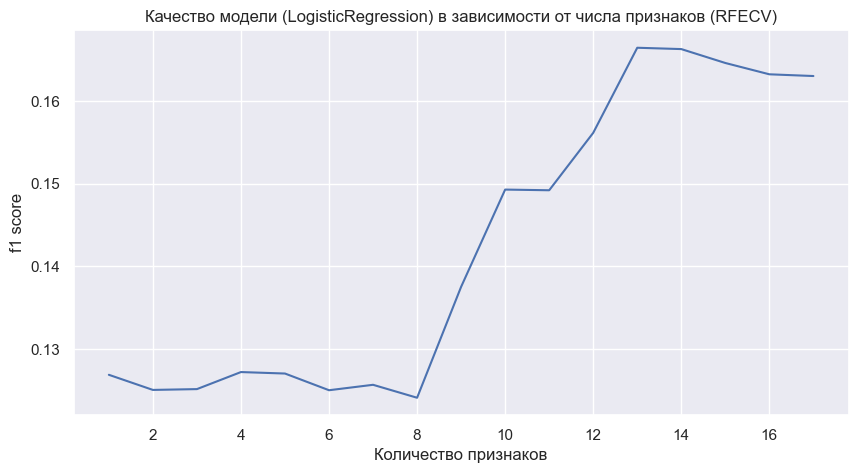

In [33]:
show_rfecv_results(X_train, y_train, logreg, 
                      scoring='f1', step=1, n_splits=2, 
                      n_jobs=6, verbose=1);

## Boruta

**Boruta** – это алгоритм выбора признаков, основанный на идее "тени признаков" (shadow features) и статистических тестах. Он сравнивает важность исходных признаков с важностью искусственно созданных случайных признаков, чтобы определить, какие из исходных фичей действительно значимы.

In [ ]:
explain_model_boruta(X_train, X_valid, y_train, y_valid, forest, max_iter=50, perc=50, n_splits=2)

ℹ️ Model type: RandomForestClassifier
ℹ️ Boruta params: max_iter=50, perc=50, alpha=0.05
ℹ️ TimeSeriesSplit n_splits: 2
🔄 Running Boruta feature selection on time series splits...
  • Fold 1/2 — Train size: 386252, Test size: 386250


# Участки где модель дает сигнал

In [28]:
# 1. Подготовка данных
df_last_2000 = df_test.iloc[-20000:-16000]
# Преобразуем строку с датой в datetime
df_last_2000['Data'] = pd.to_datetime(df_last_2000['Data'])

# Допустим, у нас есть список фичей, которые использует модель
features_columns = forest_base_line.feature_names_in_

# 2. Выделяем X_test (только фичи)
X_test_last_2000 = df_last_2000[features_columns]

# 3. Получаем вероятности классов (вместо жестких предсказаний)
probabilities = forest_base_line.predict_proba(X_test_last_2000)
df_last_2000['Probability_1'] = probabilities[:, 1]  # Вероятность класса 1 (BUY)

In [32]:
# Функция для обновления графика при изменении порога
def update_plot(threshold):
    # Создаем сигналы на основе порога
    df_last_2000['Signal'] = (df_last_2000['Probability_1'] >= threshold).astype(int)
    
    # Создаем новый график
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                       vertical_spacing=0.02,
                       row_heights=[0.7, 0.3])

    # Свечной график
    fig.add_trace(go.Candlestick(
        x=df_last_2000['Data'],
        open=df_last_2000['Open'],
        high=df_last_2000['High'],
        low=df_last_2000['Low'],
        close=df_last_2000['Close'],
        name='Цены'
    ), row=1, col=1)

    # Сигналы модели (где вероятность >= порогу)
    signals = df_last_2000[df_last_2000['Signal'] == 1]
    fig.add_trace(go.Scatter(
        x=signals['Data'],
        y=signals['Low'] * 0.99,  # маркеры чуть ниже минимумов
        mode='markers',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        name=f'Сигнал BUY (≥{threshold:.2f})'
    ), row=1, col=1)

    # Объемы торгов
    fig.add_trace(go.Bar(
        x=df_last_2000['Data'],
        y=df_last_2000['Volume'],
        name='Объем'
    ), row=2, col=1)

    # Настройки графика
    fig.update_layout(
        title=f'Тестовые предсказания модели (Порог: {threshold:.2f})',
        xaxis_rangeslider_visible=False,
        hovermode='x unified',
        height=700
    )

    # Добавляем кнопки для навигации по времени
    fig.update_xaxes(
        rangebreaks=[{'bounds': ['sat', 'mon']}],  # скрываем выходные
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1д", step="day", stepmode="backward"),
                dict(count=7, label="1н", step="day", stepmode="backward"),
                dict(count=1, label="1м", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    
    fig.show()

# Создаем слайдер для порога
threshold_slider = widgets.FloatSlider(
    value=0.6,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Порог:',
    continuous_update=False
)

# Связываем слайдер с функцией обновления
widgets.interactive(update_plot, threshold=threshold_slider)

# Отображаем слайдер и начальный график
display(threshold_slider)
update_plot(0.6)

FloatSlider(value=0.6, continuous_update=False, description='Порог:', max=1.0, step=0.01)

# Поиск оптимальной цели

In [37]:
from tqdm import tqdm
import pandas as pd

def run_target_search(df,
                      target_candles_list=[3, 5, 7, 10, 15, 20],
                      target_list=[0.015, 0.02, 0.025, 0.03, 0.04],
                      rr_threshold=2.0,
                      model_params=None,
                      test_size=0.2):

    # Параметры модели по умолчанию
    default_model_params = {
        'class_weight': 'balanced',
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_leaf': 3,
        'min_samples_split': 2,
        'max_features': 0.8,
        'max_samples': 0.8,
        'random_state': 3,
        'n_jobs': 6
    }
    
    if model_params is not None:
        default_model_params.update(model_params)
    
    results = []
    total_combinations = len(target_candles_list) * len(target_list)
    
    # Создаем progress bar для всех комбинаций
    with tqdm(total=total_combinations, desc="Processing combinations") as pbar:
        for tc in target_candles_list:
            for tgt in target_list:
                try:
                    df_local = df.copy()

                    # Обновляем целевую переменную
                    df_local = df_local.drop(columns=['target'], errors='ignore')
                    df_local = add_target_column_mod(
                        df_local, 
                        target_candles=tc, 
                        target=tgt, 
                        rr_threshold=rr_threshold
                    )

                    # Удаляем строки с NaN в target
                    df_local = df_local.dropna(subset=['target'])

                    # Разделяем на признаки и целевую переменную
                    X = df_local.drop(['target', 'Data', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1)
                    y = df_local['target']

                    # Разделяем на train/valid
                    separate = int(len(X) * (1 - test_size))
                    X_train, X_valid = X.iloc[:separate], X.iloc[separate:]
                    y_train, y_valid = y.iloc[:separate], y.iloc[separate:]

                    # Инициализируем и обучаем модель
                    model = RandomForestClassifier(**default_model_params)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_valid)

                    # Считаем метрики
                    f1 = f1_score(y_valid, y_pred)
                    precision = precision_score(y_valid, y_pred)
                    recall = recall_score(y_valid, y_pred)
                    positive_ratio = y_train.mean()

                    results.append({
                        'target_candles': tc,
                        'target': tgt,
                        'rr_threshold': rr_threshold,
                        'f1': f1,
                        'precision': precision,
                        'recall': recall,
                        'positive_ratio': positive_ratio,
                        'train_samples': len(y_train),
                        'valid_samples': len(y_valid),
                        'features_used': X.shape[1]
                    })
                    
                except Exception as e:
                    print(f"Error with tc={tc}, tgt={tgt}: {str(e)}")
                    results.append({
                        'target_candles': tc,
                        'target': tgt,
                        'rr_threshold': rr_threshold,
                        'f1': None,
                        'precision': None,
                        'recall': None,
                        'positive_ratio': None,
                        'train_samples': None,
                        'valid_samples': None,
                        'features_used': None,
                        'error': str(e)
                    })
                
                pbar.update(1)
    
    return pd.DataFrame(results)

In [69]:
# С пользовательскими параметрами модели
custom_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'n_jobs': 6
}
results_df = run_target_search(
    df=df,
    target_candles_list=[10, 20, 30, 50],
    target_list=np.arange(0.004,0.021,0.002),
    rr_threshold=1.5,
    model_params=None,
    test_size=0.2
)


Processing combinations: 100%|██████████████████████████████████████████████████████| 36/36 [1:50:48<00:00, 184.67s/it]


In [70]:
results_df.sort_values('f1', ascending=False)

,target_candles,target,rr_threshold,f1,precision,recall,positive_ratio,train_samples,valid_samples,features_used
27,50,0.004,1.5,0.512158,0.378129,0.793371,0.346217,1158752,289688,7
18,30,0.004,1.5,0.482338,0.356948,0.743527,0.297606,1158752,289688,7
9,20,0.004,1.5,0.457284,0.333150,0.728863,0.248743,1158752,289688,7
28,50,0.006,1.5,0.454141,0.328648,0.734674,0.266833,1158752,289688,7
19,30,0.006,1.5,0.419655,0.292692,0.741151,0.201305,1158752,289688,7
29,50,0.008,1.5,0.402720,0.276707,0.739480,0.195252,1158752,289688,7
0,10,0.004,1.5,0.398860,0.271247,0.753225,0.159647,1158752,289688,7
10,20,0.006,1.5,0.382221,0.256750,0.747528,0.150263,1158752,289688,7
20,30,0.008,1.5,0.355269,0.232103,0.756949,0.132729,1158752,289688,7
30,50,0.010,1.5,0.355194,0.232857,0.748375,0.142689,1158752,289688,7


In [73]:
print(results_df.sort_values('f1', ascending=False).head(10))

    target_candles  target  rr_threshold        f1  precision    recall  \
27              50   0.004           1.5  0.512158   0.378129  0.793371   
18              30   0.004           1.5  0.482338   0.356948  0.743527   
9               20   0.004           1.5  0.457284   0.333150  0.728863   
28              50   0.006           1.5  0.454141   0.328648  0.734674   
19              30   0.006           1.5  0.419655   0.292692  0.741151   
29              50   0.008           1.5  0.402720   0.276707  0.739480   
0               10   0.004           1.5  0.398860   0.271247  0.753225   
10              20   0.006           1.5  0.382221   0.256750  0.747528   
20              30   0.008           1.5  0.355269   0.232103  0.756949   
30              50   0.010           1.5  0.355194   0.232857  0.748375   

    positive_ratio  train_samples  valid_samples  features_used  
27        0.346217        1158752         289688              7  
18        0.297606        1158752         

# 🔎 12. Выводы

?

## 📋 Выбор оптимальных признаков:

In [ ]:
🔍 Top Features by Permutation Importance:
|   Rank | Feature                    |   Mean Importance |   Std | Significant   |
|-------:|:---------------------------|------------------:|------:|:--------------|
|      1 | ema20_norm                 |             0.049 | 0.000 | True          |
|      2 | ema200_norm                |             0.030 | 0.000 | True          |
|      3 | RSI21                      |             0.014 | 0.000 | True          |
|      4 | fib_dist_050_last50        |             0.010 | 0.000 | True          |
|      5 | vwap_price_distance        |             0.006 | 0.000 | True          |
|      6 | ema100_norm                |             0.006 | 0.000 | True          |
|      7 | RSI_50_21_diff             |             0.004 | 0.000 | True          |
|      8 | vwap_ema6h_norm            |             0.003 | 0.000 | True          |
|      9 | vwap_price_distance_direct |             0.002 | 0.000 | True          |
|     10 | ema50_ema100_diff          |             0.002 | 0.000 | True          |
|     11 | ema200_slope               |             0.001 | 0.000 | True          |
|     12 | ema100_slope               |             0.001 | 0.000 | True          |
|     13 | ema100_ema200_diff         |             0.001 | 0.000 | True          |
|     14 | vwap_ema6h_zscore          |             0.001 | 0.000 | True          |

In [10]:
base_features = ['ema20_norm', 
                 'ema200_norm',
                'RSI21',
                'fib_dist_050_last50',
                'vwap_price_distance',
                 'ema100_norm',
                 'RSI_50_21_diff',
                 'vwap_ema6h_norm',
                 'vwap_price_distance_direct',
                 'ema50_ema100_diff',
                 'ema200_slope',
                 'ema100_slope',
                 'ema100_ema200_diff',
                 'vwap_ema6h_zscore',
                'Data', 'High', 'Low', 'Close', 'Open', 'Volume','target']